### Backpropagation using Micrograd

In [28]:
import math
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline

In [29]:
class Value:

    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        self.prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0
        self._backward = lambda: None
        
    def __repr__(self):
        return f"Value(data{self.data})"
    
    def __neg__(self):
        return self * -1

    def __add__(self, other):
        # enable integer addition
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), "+")

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward

        return out
    
    def __sub__(self, other):
        return self + (-other)

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), "*")

        def _backward():
            self.grad += out.grad * other.data
            other.grad += out.grad * self.data
        out._backward = _backward

        return out
    
    # in the case of int * Value, __mul__ fails and python will swap the other of the
    # operands and tries __rmul__
    def __rmul__(self, other): # other * self
        return self * other 
    
    def __pow__(self, other):
        assert isinstance(other, (int, float))
        x = self.data
        v = math.pow(x, other)
        out = Value(v, (self, ), _op = f"^{other}")

        def _backward():
            self.backward = other * self.data**(other-1) * out.grad
        out._backward = _backward

        return out

    def __truediv__(self, other):
        return self * other**-1
    
    def tanh(self):
        t = (math.exp(2*self.data)-1)/(math.exp(2*self.data)+1)
        out = Value(t, (self, ), _op = 'tanh')

        def _backward():
            self.grad = (1 - t**2) * out.grad 
        out._backward = _backward

        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), _op='exp')

        def _backward():
            self.backward = out.data * out.grad
        out._backward = _backward

        return out

    def backward(self):
        # Use topological sort to reverse the order of nodes
        topo = []
        visited = set()

        def tbuild(v):
            if v not in visited:
                visited.add(v)
                for child in v.prev:
                    tbuild(child)
                topo.append(v)

        tbuild(self)
        self.grad = 1.0
        
        for node in reversed(topo):
            node._backward()

In [30]:
a = Value(2.0, label="a")
b = Value(-3.0, label="b")
c = Value(10.0, label="c")
e = a*b; e.label = "e"
d = e + c; d.label = "d"
f = Value(-2.0, label="f")
L = d*f; L.label = "L"

In [31]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v.prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    # Set rankdir to 'LR' (Left to Right) and add it properly in the graph attributes
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # Use records for value nodes (rectangular shape with compartments)
        dot.node(name = uid, label = f"{{ {n.label} | data {n.data:.4f} | grad {n.grad:.4f} }}", shape='record')
        
        if n._op:
            op_node_name = uid + n._op
            dot.node(name=op_node_name,
                    label=n._op)
            dot.edge(op_node_name, uid)
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

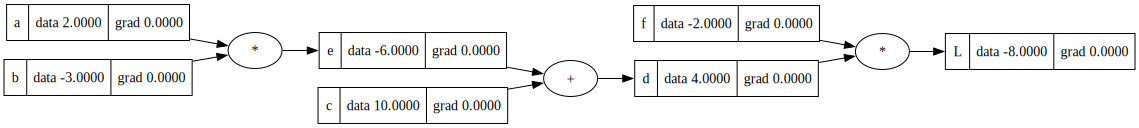

In [32]:
draw_dot(L)

### How to manually find the gradients? 

### Example of how changing values in the direction of the gradient increases value of L

### Backpropagating through a double layer Neuron

We use the activation function, tanh, which is bounded, i.e for inputs higher than a certain number the output plateaus at 1

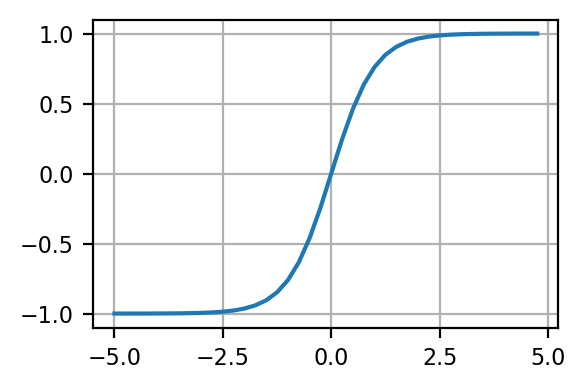

In [33]:
plt.figure(figsize=(3, 2), dpi=200); plt.plot(np.arange(-5, 5, 0.25), np.tanh(np.arange(-5, 5, 0.25))); plt.grid(); plt.xticks(fontsize=8); plt.yticks(fontsize=8)
plt.show()

In [34]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.88, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

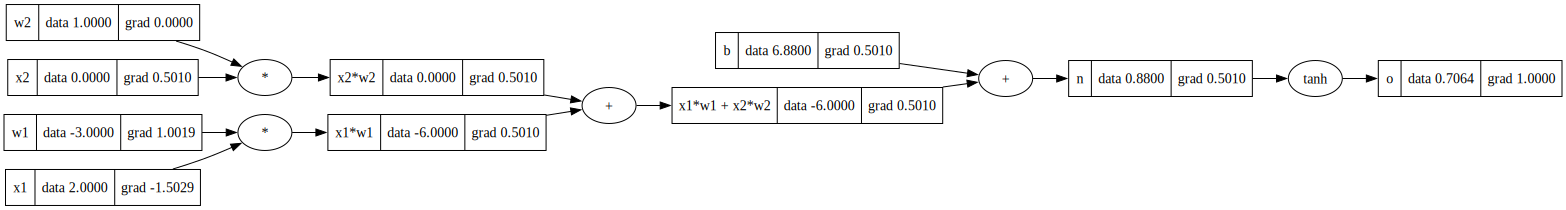

In [35]:
# Manually Implementing BP
# o.grad = 1.0
# n.grad = 1-(o.data)**2
# b.grad = n.grad
# x1w1x2w2.grad = n.grad 
# x2w2.grad, x1w1.grad = x1w1x2w2.grad, x1w1x2w2.grad
# w1.grad = x1w1.grad * x1.data
# x1.grad = x1w1.grad * w1.data
# x2.grad = x2w2.grad * w2.data
# w2.grad = x2w2.grad * x2.data

# Instead, call the backward function in right order
# o.grad = 1.0 
# o._backward()
# n._backward()
# b._backward()
# x1w1x2w2._backward()
# x2w2._backward()
# x1w1._backward()

o.backward()
draw_dot(o)

### Doing the same using PyTorch

In [36]:
import torch

# use .double to use float64
x1 = torch.tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.tensor([1.0]).double(); w2.requires_grad = True

b = torch.tensor([6.88]).double(); b.requires_grad = True

n = x1 * w1 + x2 * w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('-----')
print('x1 ', x1.grad.item())
print('x2 ', x2.grad.item())
print('w1 ', w1.grad.item())
print('w2 ', w2.grad.item())

0.7064193777288968
-----
x1  -1.5029149883073547
x2  0.5009716627691182
w1  1.0019433255382364
w2  0.0
